### First download the dataset and put it the same folder level as this notebook.

[UCI dataset](https://archive.ics.uci.edu/dataset/908/realwaste)

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    # TODO add data agumentation here
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

data_path = 'realwaste-main/RealWaste'
model_path = 'models/model.pth'
dataset = datasets.ImageFolder(root=data_path, transform=transform)


dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

n_classes = len(dataset.classes)
images, labels = next(iter(dataloader))

In [23]:
images[0].shape, len(dataset), dataset.classes, dataset, Counter(dataset.targets)

(torch.Size([3, 224, 224]),
 4752,
 ['Cardboard',
  'Food Organics',
  'Glass',
  'Metal',
  'Miscellaneous Trash',
  'Paper',
  'Plastic',
  'Textile Trash',
  'Vegetation'],
 Dataset ImageFolder
     Number of datapoints: 4752
     Root location: realwaste-main/RealWaste
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Counter({6: 921,
          3: 790,
          5: 500,
          4: 495,
          0: 461,
          8: 436,
          2: 420,
          1: 411,
          7: 318}))

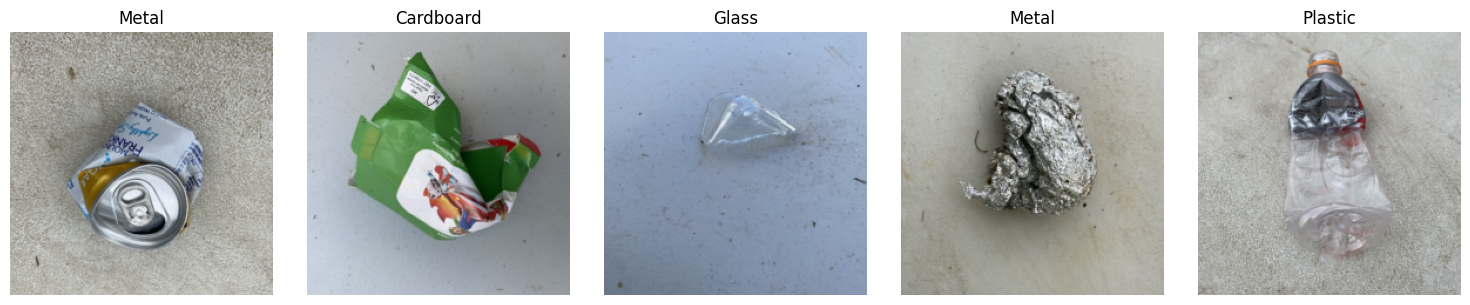

In [24]:
import matplotlib.pyplot as plt


# Let's show the first 5 images
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 3))  # 1 row, N columns
class_names = dataset.classes 
for i in range(num_images):
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5             # Undo normalization if applied
    
    axs[i].imshow(img)
    axs[i].set_title(class_names[labels[i]])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [34]:
# split the dataset into train-eval-test with 70:10:20 ratio
from torch.utils.data import WeightedRandomSampler

dataset_len = len(dataset)
train_len = int(0.7*dataset_len)
eval_len = int(.1*dataset_len)
test_len= int(dataset_len - train_len - eval_len)

train_set,eval_set, test_set = random_split(dataset,[train_len,eval_len,test_len])



label_counts = [0]*n_classes
for i in train_set.indices:
    label = dataset.targets[i]
    label_counts[label] += 1
num_classes = len(label_counts)
total = len(train_set)
weights = [total / ( num_classes* label_counts[cls]) for cls in range(num_classes)]

label_weights = [weights[dataset.targets[i]] for i in train_set.indices]
# Create a weighted sampler
sampler = WeightedRandomSampler(label_weights, total, replacement=True)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
eval_loader = DataLoader(eval_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

len(train_loader),len(eval_loader), len(test_loader)

(104, 15, 30)

In [26]:
label_weights[:10],weights

([0.6694847020933977,
  1.0439422473320779,
  1.6424691358024692,
  1.1370940170940171,
  0.5801500087214373,
  0.6694847020933977,
  1.1657903960743077,
  1.269950362733868,
  1.1657903960743077,
  1.147688060731539],
 [1.147688060731539,
  1.269950362733868,
  1.2196552988632197,
  0.6694847020933977,
  1.0439422473320779,
  1.1370940170940171,
  0.5801500087214373,
  1.6424691358024692,
  1.1657903960743077])

In [2]:
# Create the model here
class Model(torch.nn.Module):
    def __init__(self, n_cls):
        super(Model, self).__init__()
        self.n_cls = n_cls
        
        # Convolutional Layers
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),  # Output: 16x112x112
            torch.nn.Dropout(0.3)
        )
        
        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),  # Output: 32x56x56
            torch.nn.Dropout(0.3)
        )
        
        self.conv_block3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),  # Output: 64x28x28
            torch.nn.Dropout(0.3)
        )
        
        self.conv_block4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),  # Output: 128x14x14
            torch.nn.Dropout(0.3)
        )

        # Fully Connected Layers
        self.fc_block = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 14 * 14, 8192),
            torch.nn.BatchNorm1d(8192),
            torch.nn.ReLU(),
            torch.nn.Linear(8192, 4096),
            torch.nn.BatchNorm1d(4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, self.n_cls)
        )

    def forward(self, x):
        # Pass through convolutional blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        
        # Pass through fully connected layers
        x = self.fc_block(x)
        return x
  

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01,path=model_path):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Model(n_classes).to(device)

In [30]:
# define the loss and optimizer
from torch.nn import CrossEntropyLoss
from  torch.optim import Adam

criterion = CrossEntropyLoss()
optimizer =Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=7, delta=0.01)

In [31]:
from tqdm import tqdm 
# train here
n_epochs = 100

for i in tqdm(range(n_epochs)):
    train_loss = 0
    model.train()

    for input,target in train_loader:
        input = input.to(device)
        target = target.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(input)

        # calculate loss
        loss = criterion(outputs,target)
        train_loss +=loss.item()
        # backpropagation 
        loss.backward()
        optimizer.step()


    
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for input,target in eval_loader:
            input = input.to(device)
            target = target.to(device)
            
            # forward pass
            outputs = model(input)

            loss = criterion(outputs,target)
            eval_loss+=loss.item()
            # check for early stopping
    
    early_stopping(eval_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # eval 
    print(train_loss,eval_loss)


  1%|          | 1/100 [00:28<47:02, 28.51s/it]

153.86888045072556 29.851918697357178


  2%|▏         | 2/100 [00:56<46:06, 28.23s/it]

116.45226567983627 26.894286394119263


  3%|▎         | 3/100 [01:23<44:45, 27.68s/it]

94.98050427436829 26.74223804473877


  4%|▍         | 4/100 [01:49<42:57, 26.84s/it]

77.97390949726105 28.36381208896637


  5%|▌         | 5/100 [02:16<42:34, 26.88s/it]

63.18629491329193 24.49662971496582


  6%|▌         | 6/100 [02:42<41:49, 26.69s/it]

50.61396826803684 30.05508589744568


  7%|▋         | 7/100 [03:06<40:14, 25.97s/it]

41.30880703032017 24.62523365020752


  8%|▊         | 8/100 [03:31<39:16, 25.61s/it]

33.738164357841015 28.304677844047546


  9%|▉         | 9/100 [03:56<38:25, 25.34s/it]

25.127638407051563 26.890388011932373


 10%|█         | 10/100 [04:21<37:44, 25.16s/it]

22.727957256138325 26.004459023475647


 11%|█         | 11/100 [04:45<37:07, 25.03s/it]

19.698976423591375 27.864073276519775


 11%|█         | 11/100 [05:12<42:09, 28.42s/it]

Early stopping


In [32]:
# load the best model
model.load_state_dict(torch.load(model_path))
model.eval()

Model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inpla

In [33]:
# test here
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
y_true = []
y_pred = []     
with torch.no_grad():
    for input,target in test_loader:
        input = input.to(device)
        target = target.to(device)
        
        # forward pass
        outputs = model(input)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Classification report
report = classification_report(y_true, y_pred, target_names=dataset.classes)
print(report)
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 55.52%
                     precision    recall  f1-score   support

          Cardboard       0.80      0.49      0.61        87
      Food Organics       1.00      0.16      0.28        69
              Glass       0.34      0.89      0.49        80
              Metal       0.55      0.67      0.60       169
Miscellaneous Trash       0.51      0.47      0.49       100
              Paper       0.95      0.47      0.63       128
            Plastic       0.51      0.61      0.55       181
      Textile Trash       0.36      0.14      0.20        58
         Vegetation       0.88      0.81      0.84        79

           accuracy                           0.56       951
          macro avg       0.65      0.52      0.52       951
       weighted avg       0.64      0.56      0.55       951

Confusion Matrix:
[[ 43   0  23   4   2   0  15   0   0]
 [  0  11   7   6   9   0  29   0   7]
 [  0   0  71   5   2   0   2   0   0]
 [  1   0  24 114   5   0  25   0   0]
 [  3   0  10

<Axes: >

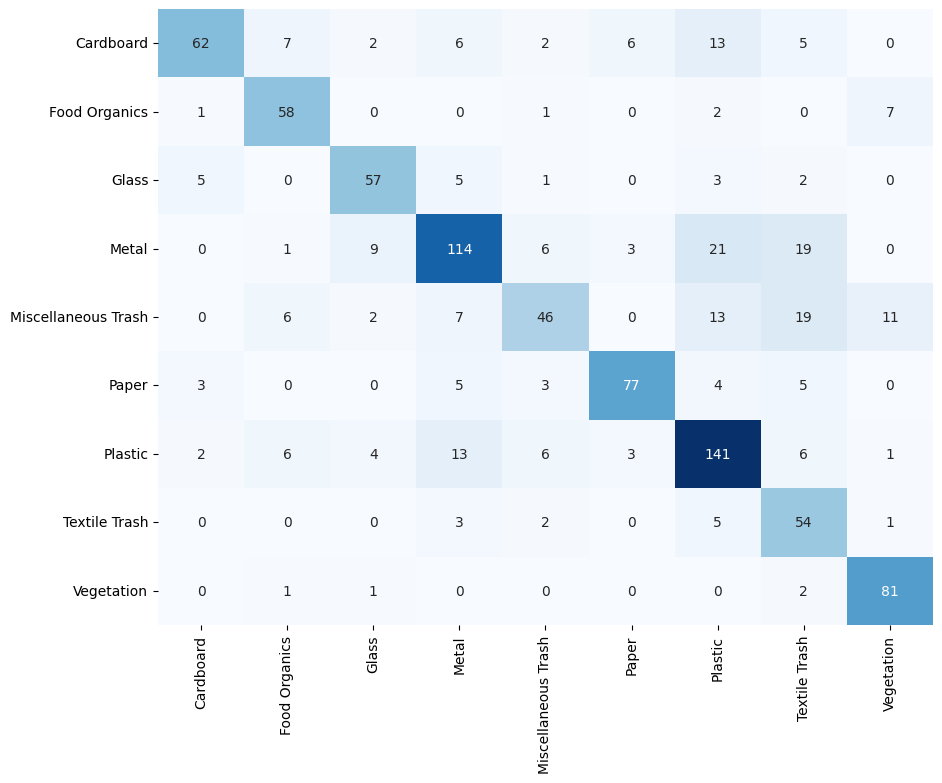

In [21]:
# visualize the test results here
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)           